In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
from cell_obj import CellObj, add_measured_value, save_objects_as_pickle
import pickle

In [2]:
cell_object_list_path = 'cell_list_for_labeling.pickle'
cell_list = []
#Opening file and unpuckling its content
with open(cell_object_list_path , 'rb') as pickled_file:
    cell_list = pickle.load(pickled_file)

In [3]:
image_hash = cell_list[0].original_image_hash

# Descriptive statistics for DF

In [4]:
df = pd.read_csv(f'csvs/{image_hash}.csv')
columns_list = df.columns

In [5]:
df.describe()

,feret_diameter_max,perimeter,eccentricity,center_of_mass_x,center_of_mass_y,mean_intensity,mean_std,cor_coefficient,p_value
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0
mean,23.591545,66.048767,0.558423,152.305556,118.194444,31.897778,51.628889,0.410000,0.0
std,2.660846,7.854513,0.091024,80.136248,66.631532,4.402978,7.954620,0.053772,0.0
min,18.384776,52.870058,0.328804,21.000000,13.000000,25.220000,41.750000,0.280000,0.0
25%,21.987123,61.491378,0.495405,87.500000,62.750000,28.567500,44.987500,0.390000,0.0
50%,23.173100,64.819805,0.568482,151.500000,117.000000,31.365000,50.285000,0.415000,0.0
75%,25.014982,67.941125,0.626167,228.000000,169.000000,34.117500,54.835000,0.440000,0.0
max,30.413813,86.426407,0.750566,290.000000,233.000000,43.220000,71.320000,0.550000,0.0


In [6]:
columns_for_analysis = ['feret_diameter_max', 'perimeter', 'mean_intensity', 'cor_coefficient']

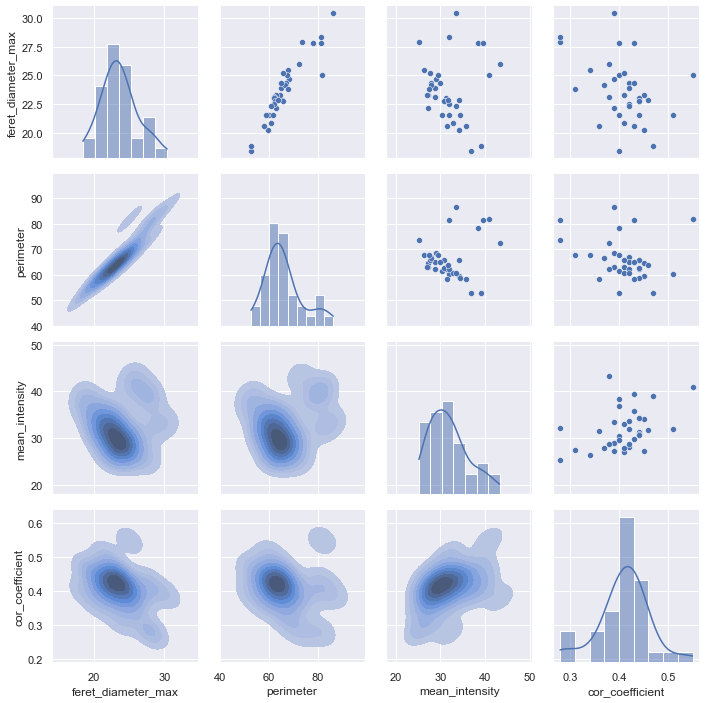

In [7]:
# pair grid
# https://seaborn.pydata.org/tutorial/distributions.html
g = sns.PairGrid(df[columns_for_analysis])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

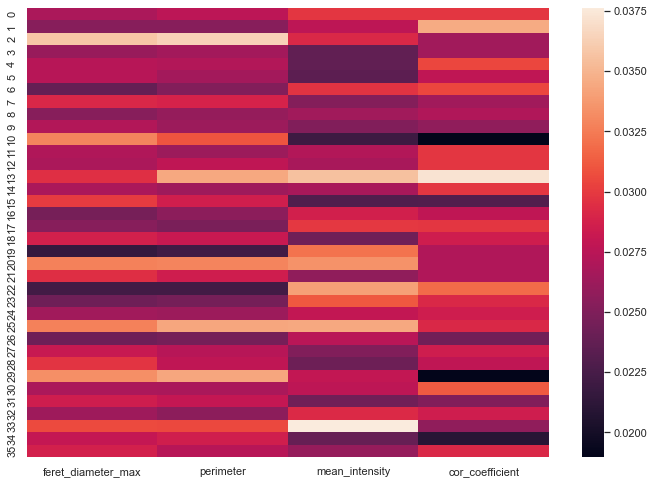

In [8]:
# heat map on normalizied image
df_norm = df / df.sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(df_norm[columns_for_analysis])


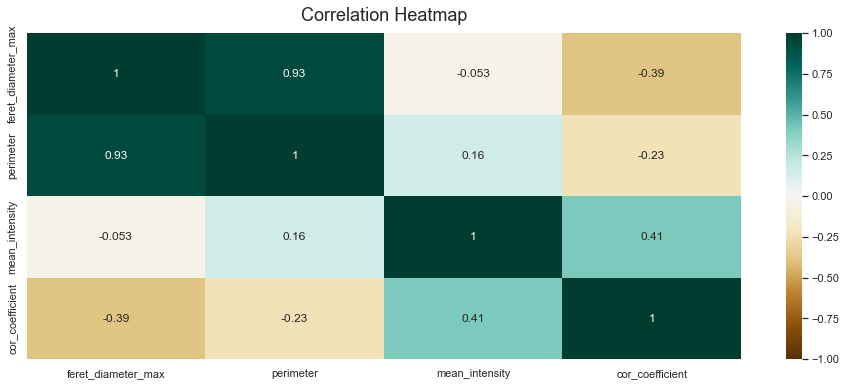

In [9]:
#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[columns_for_analysis].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# Machine Learning

KMeans implementation. Other ML algorithms can be implemeneted.

In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [11]:
features = ['feret_diameter_max', 'perimeter', 'eccentricity']

In [12]:
def fit_KMeans(data,show_metrics=True):
    '''fiting a clustering algorithm to a traning data'''
    X = np.array(data)
    scaler = StandardScaler()
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    model = KMeans(n_clusters=2, random_state=0).fit(X)
    labels = model.labels_
    return model, scaler
model, scaler =  fit_KMeans(df[features])


In [13]:
def calculate_label_KMeans(cell_obj, model, scaler, features):
    '''returns a dict of labels from machine learning model'''
    # create feature vector from img_obj:
    values_list = []
    for key, value in cell_obj.measured_values.items():
        if key in features:
            values_list.append(value)
    X = np.array(values_list) 
    X = X.reshape(1, -1)
    X = scaler.transform(X)
    label = int(model.predict(X))
    return {'KMeans_label': label}

In [14]:
def add_measured_value(cell_obj_list, function, **kwargs):
    '''Using a separate function adds a value to every cell object in a list'''
    new_cell_obj_list = []
    
    for cell_obj in cell_obj_list:
        props = function(cell_obj, **kwargs)
        # accepts return as a dictionary, iterates over dictionary and adds it to value dictionary
        for key, value in props.items():
            cell_obj.measured_values[key] = value
        new_cell_obj_list.append(cell_obj)
        
    return new_cell_obj_list

In [15]:
new_cell_list = add_measured_value(cell_list, calculate_label_KMeans, model=model,
                                   scaler=scaler,  features=features)

In [16]:
save_objects_as_pickle(cell_list, 'cell_list_for_labeling')